# Introduction
For more details, could refer to the [pdf report](https://github.com/DavideEspositoPelella/Anomaly_Detection_GAN_Based.git/Report) or the [GitHub repository](https://github.com/DavideEspositoPelella/Anomaly_Detection_GAN_Based.git)  <a href="https://github.com/DavideEspositoPelella/Anomaly_Detection_GAN_Based.git"><img src="https://github.githubassets.com/pinned-octocat.svg" alt="GitHub" height="30" style="filter: invert(1);"></a>.

The following Colab notebook represents the work carried out within the context of the Deep Learning Project, which takes its starting point from the paper: [[1]](#Bibliography) _**GAN-based Anomaly Detection in Imbalance Problems**_. 

It revisits the state-of-arts as presented in the research mentioned and includes 2 comparative baselines: a RandomGuesser and an Autoencoder. Subsequently, it assesses their performances by utilizing the [[3]](#Bibliography) _AUROC (Area Under the Receiver Operating Characteristic)_ metric.

<a href="https://colab.research.google.com/drive/1XKohwPFibuQDeruwHoRtRP4fjYGqGN3M?usp=drive_link"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="google colab logo" height=30px></a>

Unfortunately the presented work was had dealed with hardware limitations, which, because provided by the Google Colab service, restricted the GPU availability time. 


# Imports
Importing all the libraries and dependencies needed.

In [ ]:
! pip install --quiet "pytorch-lightning"
! pip install --quiet gdown

In [1]:
import os
import torch
import torch.nn as nn
import pytorch_lightning as pl
import torchvision.transforms as T
from torchvision.datasets import FashionMNIST
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
import platform
import random

print("Lightning version:", pl.__version__)
print("PyTorch version:", torch.__version__)
print("Python version:", platform.python_version())


Lightning version: 2.0.7
PyTorch version: 2.0.1+cu118
Python version: 3.10.8


Setting a seed for reproducibility

In [2]:
pl.seed_everything(42)

Global seed set to 42


42

# Dataset and Preprocessing
The pythorch lightning class _AnomalyDetectionDataModule_ allow to load autonomously the dataset of FashionMNIST [[2]](#bibliography), preprocess it and then performing training and testing. 

In the class is defined a custom function _Rotation3_ to perform augmentation on the images by randomly rotating them as showed in the research paper. Then, togheter with this were performed other augmentations to improve the perfromances.

The DataModule class, perform also the preprocessing needed to deal with the unbalance problem discussed in the paper. To do this it allow to divide the dataset, originaly composed of 10 classes, into 2 as 'normal' and 'anomal', by setting by input the value of _normal_class_ variable and automatically setting al the remaining classes as anomal. 

At this point the dataset is clearly unbalanced, for this reason is used the _kmeans_sampling_ function. It uses for the normal class all the available samples (could be reduced by choice), while a sampling is performed to get the same number of samples for the anomal class. In order to consider the distribution of the data is used a k-means clustering of the remaining classes before the sampling.

In [3]:
# Randomly rotate the images by 90, 180, or 270 degrees
class Rotation3:
    def __call__(self, img):
        angle = random.choice([0, 90, 180, 270])
        img = T.functional.rotate(img, angle)
        return img

# DataModule
class AnomalyDetectionDataModule(pl.LightningDataModule):
    def __init__(self, batch_size, subsampling, subsamples, model, normal_class, data_dir="./"):
        super().__init__()

        self.model = model
        self.normal_class = normal_class
        self.subsampling = subsampling
        self.subsamples = subsamples

        self.train_transform = T.Compose([
            T.Resize(32),
            T.RandomVerticalFlip(),
            T.RandomHorizontalFlip(),
            T.RandomCrop(30),
            T.Resize(32),
            T.Grayscale(1),  # Use 1 channel (grayscale)
            T.RandomApply([Rotation3()], p=1),
            T.ToTensor(),
            T.Normalize([0.5], [0.5])
        ])
        self.test_transform = T.Compose([
            T.Resize(32),
            T.Grayscale(1),  # Use 1 channel (grayscale)
            T.ToTensor(),
            T.Normalize([0.5], [0.5])
        ])

        self.data_dir = data_dir
        self.dataset_classes = 10
        self.num_classes = 2  # Normal and Anomaly
        self.batch_size = batch_size
        self.num_clusters = self.dataset_classes - 1
        self.subsamples = subsamples
        self.subsampling = subsampling

    # K-means based sampling of anomal classes
    def kmeans_sampling(self, dataset, normal_class, num_samples):
        indices = [i for i in range(len(dataset)) if dataset.targets[i] != normal_class]
        class_data = torch.stack([dataset[i][0] for i in indices])
        kmeans = KMeans(n_clusters=self.num_clusters, random_state=0, n_init=9)
        kmeans.fit(class_data.view(class_data.size(0), -1).numpy())
        cluster_assignments = kmeans.predict(class_data.view(class_data.size(0), -1).numpy())
        sampled_indices = []
        for cluster_idx in range(self.num_clusters):
            cluster_indices = np.where(cluster_assignments == cluster_idx)[0]
            num_samples_from_cluster = num_samples//self.num_clusters
            sampled_indices.extend(np.random.choice(cluster_indices, num_samples_from_cluster, replace=False))
        return [indices[idx] for idx in sampled_indices]

    def prepare_data(self):
        FashionMNIST(root=self.data_dir, train=True, download=True)

    def setup(self, stage=None):

        if stage == 'fit' or stage is None: # Setup dataset for training phase

            if self.model == 'GAN' or self.model == 'RG':
                all_data = []
                all_labels = []
                normal_data  = []
                anomal_data = []
                normal_class = self.normal_class

                # Load dataset
                train_dataset = FashionMNIST(root=self.data_dir, train=True, transform=self.train_transform)

                # Use 1 class as 'normal' and the other as 'anomal'
                normal_indices = [i for i in range(len(train_dataset)) if train_dataset.targets[i] == normal_class]
                anomal_indices = self.kmeans_sampling(train_dataset, normal_class, num_samples=len(normal_indices))

                # Use only a subset of dataset
                if self.subsampling == True:
                    normal_indices = normal_indices[:self.subsamples]
                    anomal_indices = anomal_indices[:self.subsamples]

                normal_labels = torch.ones(len(normal_indices), dtype=torch.float32)
                anomal_labels = torch.zeros(len(anomal_indices), dtype=torch.float32)

                normal_data.extend([train_dataset[i][0] for i in normal_indices])
                anomal_data.extend([train_dataset[i][0] for i in anomal_indices])

                all_data.extend(normal_data)
                all_data.extend(anomal_data)
                all_labels.extend(normal_labels)
                all_labels.extend(anomal_labels)

                all_data = torch.stack(all_data)
                all_labels = torch.tensor(all_labels)

                # Build the new dataset following requirements
                self.train_dataset = torch.utils.data.TensorDataset(all_data, all_labels)

            else:
                all_data = []
                all_labels = []
                normal_data  = []
                normal_class = self.normal_class

                # Load dataset
                train_dataset = FashionMNIST(root=self.data_dir, train=True, transform=self.train_transform)

                # Use only one class
                normal_indices = [i for i in range(len(train_dataset)) if train_dataset.targets[i] == normal_class]

                # Use only a subset of dataset
                if self.subsampling == True:
                    normal_indices = normal_indices[:self.subsamples]

                normal_labels = torch.ones(len(normal_indices), dtype=torch.float32)

                normal_data.extend([train_dataset[i][0] for i in normal_indices])

                all_data.extend(normal_data)
                all_labels.extend(normal_labels)

                all_data = torch.stack(all_data)
                all_labels = torch.tensor(all_labels)

                # Build the new dataset following requirements
                self.train_dataset = torch.utils.data.TensorDataset(all_data, all_labels)
                

        if stage == 'test' or stage is None: # Setup dataset for training phase

            all_data = []
            all_labels = []
            normal_data  = []
            anomal_data = []
            normal_class = self.normal_class

            # Load test dataset
            test_dataset = FashionMNIST(root=self.data_dir, train=False, transform=self.test_transform)

            normal_indices = [i for i in range(len(test_dataset)) if test_dataset.targets[i] == normal_class]
            anomal_indices = self.kmeans_sampling(test_dataset, normal_class, num_samples=len(normal_indices))

            if self.subsampling == True:
                normal_indices = normal_indices[:self.subsamples]
                anomal_indices = anomal_indices[:self.subsamples]

            normal_labels = torch.ones(len(normal_indices), dtype=torch.float32)
            anomal_labels = torch.zeros(len(anomal_indices), dtype=torch.float32)

            normal_data.extend([test_dataset[i][0] for i in normal_indices])
            anomal_data.extend([test_dataset[i][0] for i in anomal_indices])

            all_data.extend(normal_data)
            all_data.extend(anomal_data)
            all_labels.extend(normal_labels)
            all_labels.extend(anomal_labels)

            all_data = torch.stack(all_data)
            all_labels = torch.tensor(all_labels)

            # Build the new dataset
            self.test_dataset = torch.utils.data.TensorDataset(all_data, all_labels)

    def train_dataloader(self):
        return torch.utils.data.DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)

    def test_dataloader(self):
        return torch.utils.data.DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=True)


# Models
Here follows the 3 models, each  defined as _LightningModule_ and modular with the DataModule previously defined.

## GAN
The GAN-based takes place from the state-of-art approach presented in the paper [[1]](#bibliography). It consists of a Generator and two Discriminators (Normal and Anomal):
- **Generator** = Takes the symmetrical structure from the U-Net[[4]](#bibliography). It consits of four 4x4 convolutions with stride 2 and four transposed convolutions;
- **Discriminator** = Is a general CNN network. It consists of three 4x4 convolutions with stride 2, followed by two 4x4 convolutions with stride 1.

The 2 discriminators are used only in the training phase, while the _generator_ is trained to output 1 from normal data and 0 from anomaly data  thanls to the double _discriminator_, where a single one would have leaded to correctly identify only the normal data.

For the training where used 8 loss functions, 6 for the _generator_, 1 for _normal_discriminator_ and 1 for _anomal_discriminator_ , resulting in a final weighted sum of the losses to update the weights, separately for normal and anomal in order to solve loss scale imbalance. 

In [4]:

class ENCODER(pl.LightningModule):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=4, stride=2, padding=1)  #out 16x16
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1) #out 8x8
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1) #out 4x4
        self.conv4 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1) #out 2x2

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        return x

class DECODER(pl.LightningModule):
    def __init__(self):
        super().__init__()

        self.tr_conv1 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=4, stride=2, padding=1) #out 4x4
        self.tr_conv2 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1) #out 8x8
        self.tr_conv3 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1) #out 16x16
        self.tr_conv4 = nn.ConvTranspose2d(in_channels=64, out_channels=1, kernel_size=4, stride=2, padding=1) #out 32x32

    def forward(self, x):
        x = F.relu(self.tr_conv1(x))
        x = F.relu(self.tr_conv2(x))
        x = F.relu(self.tr_conv3(x))
        x = F.tanh(self.tr_conv4(x))
        return x


class GENERATOR(pl.LightningModule):
    def __init__(self):
        super().__init__()

        self.encoder = ENCODER()
        self.decoder = DECODER()

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


class DISCRIMINATOR(pl.LightningModule):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=4, stride=2, padding=1)  #out 32x16x16
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1) #out 64x8x8
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1) #out 128x4x4
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=4, stride=1, padding=1) #out 32x3x3
        self.conv5 = nn.Conv2d(in_channels=32, out_channels=1, kernel_size=4, stride=1, padding=1) #out 1x2x2

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        return x


class GAN_SOTA(pl.LightningModule):
    def __init__(self, lr=0.0002, display=False, b1=0.5, b2=0.999):
        super().__init__()
        self.lr = lr
        self.display = display

        self.save_hyperparameters()
        self.G = GENERATOR()
        self.Enc = self.G.encoder
        self.D_norm = DISCRIMINATOR()
        self.D_anom = DISCRIMINATOR()

        self.automatic_optimization = False
        self.test_step_outputs = [[], []]  # two dataloaders
        self.auroc = 0

    def forward(self, x):
        return self.G(x)

    def print_generator_parameters(self):
        for name, param in self.G.named_parameters():
            print(f"Generator Parameter Name: {name}")
            print(f"Parameter Value:\n{param}")

    def patch_loss(self, X, generated_X, n=3):
        # Calculate the L1 loss for each patch
        patch_errors = torch.abs(X - generated_X)
        patch_errors_reshaped = patch_errors.view(patch_errors.size(0), patch_errors.size(1), -1)
        mean_patch_errors = patch_errors_reshaped.mean(dim=-1)

        # Select the top n patches
        sorted_patch_indices = torch.argsort(mean_patch_errors, dim=-1, descending=True)
        top_patch_indices = sorted_patch_indices[:, :n]

        # Calculate the average of the top n patch errors
        top_patch_errors = torch.gather(mean_patch_errors, dim=-1, index=top_patch_indices)
        avg_top_patch_errors = top_patch_errors.mean()
        return avg_top_patch_errors

    def show_batch_image(self, batch):
        X, Y = batch
        image = X[0].detach().cpu().numpy()
        plt.figure(figsize=(5, 5))
        plt.title("Label: {}".format(Y[0]))
        plt.imshow(image[0], cmap='gray')  # Assuming the input image is single-channel (gray)
        plt.axis('off')
        plt.show()


    #The generator is trained to output 1 from normal data and 0 from anomaly data
    def training_step(self, batch, batch_idx):
        g_opt, d_norm_opt, d_anom_opt = self.optimizers()

        X, Y = batch
        batch_size = X.shape[0]

        real_label = torch.ones((batch_size, 1, 2, 2), device=self.device)
        fake_label = torch.zeros((batch_size, 1, 2, 2), device=self.device)

        errD_anomal = 0
        errD_normal = 0

        if (Y.squeeze() == 1):  # Normal Case
            generated_X = self.G(X)
            discriminated_X = self.D_norm(X)
            discriminated_G = self.D_norm(generated_X)
            encoded_X = self.G.encoder(X)

            # Optimize Discriminator #
            d_norm_opt.zero_grad()

            # NORM ADV LOSS
            Norm_adv_loss = (((discriminated_X - real_label)**2) + ((discriminated_G - fake_label)**2))

            errD_normal = (Norm_adv_loss.mean())

            errD = errD_normal
            self.manual_backward(errD_normal.mean())
            d_norm_opt.step()

            # Optimize Generator #
            g_opt.zero_grad()

            generated_X = self.G(X)
            discriminated_X = self.D_norm(X)
            discriminated_G = self.D_norm(generated_X)
            encoded_X = self.G.encoder(X)

            # L1 RECONSTRUCTION ERROR
            l1_loss = F.l1_loss(X, generated_X)

            # PATCH L1 LOSS
            patch_loss = self.patch_loss(X, generated_X)

            # LATENT VECTOR LOSS
            latent_loss = F.l1_loss(encoded_X, self.G.encoder(generated_X))

            # ADVERSARIAL LOSS
            norm_adv_loss = ((discriminated_G - real_label)**2)

            errG_normal = patch_loss*(1.5) + (norm_adv_loss)*(0.5) + (latent_loss)*(0.5) + (l1_loss)*(1.5)
            errG = errG_normal.mean()
            self.manual_backward(errG_normal.mean())
            g_opt.step()

            self.log_dict({"g_loss": torch.tensor(errG).mean(), "d_normal_loss": torch.tensor(errD).mean()}, prog_bar=True)

        else:  # Anomal Case
            generated_X = self.G(X)
            discriminated_X = self.D_anom(X)
            discriminated_G = self.D_anom(generated_X)

            # Optimize Discriminator #
            d_anom_opt.zero_grad()

            # ANOM ADV LOSS
            Anom_adv_loss = ((((discriminated_X - real_label)**2) + ((discriminated_G - fake_label)**2)))

            errD_anomal = (Anom_adv_loss.mean())

            errD = errD_anomal
            self.manual_backward(errD_anomal.mean())
            d_anom_opt.step()

            # Optimize Generator #
            g_opt.zero_grad()
            generated_X = self.G(X)
            discriminated_X = self.D_anom(X)
            discriminated_G = self.D_anom(generated_X)
            encoded_X = self.G.encoder(X)

            # ANOM ADVERS LOSS
            anom_adv_loss = ((discriminated_G - fake_label)**2)

            # ABC LOSS
            abc_loss = -torch.log(1 - torch.exp(-F.l1_loss(generated_X, X)))

            errG_anomal = anom_adv_loss*(1) + (abc_loss)*(0.5)
            errG = errG_anomal.mean()
            self.manual_backward(errG_anomal.mean())
            g_opt.step()

            self.log_dict({"g_loss": errG, "d_anomal_loss": errD}, prog_bar=True)

        return {"g_loss": errG, "d_norm_loss": errD_normal, "d_anom_loss": errD_anomal}

    def test_step(self, batch, batch_idx):
        X, Y = batch

        generated_X = self.G(X)

        # Calculate L1 reconstruction error instead of MSE
        reconstruction_error = F.mse_loss(generated_X, X, reduction='none')
        reconstruction_error = reconstruction_error.view(reconstruction_error.size(0), -1).mean(dim=1)  # Calculate mean error over pixels
        self.test_step_outputs[0].append(reconstruction_error)
        self.test_step_outputs[1].append(Y)

        if self.display:
            print("generated_X:", generated_X)
            print("reconstruction_error:", reconstruction_error)
            self.show_batch_image(batch)

        return {"reconstruction_error": reconstruction_error, "true_labels": Y}

    def on_test_epoch_end(self):
        all_reconstruction_errors = torch.cat(self.test_step_outputs[0])
        all_true_labels = torch.cat(self.test_step_outputs[1])

        anomaly_threshold = 0.5
        predicted_labels = (all_reconstruction_errors < anomaly_threshold).float().cpu().numpy()
        true_labels = all_true_labels.squeeze().float().cpu().numpy()

        # Calculate AUROC
        auroc = roc_auc_score(true_labels, predicted_labels)

        self.log("auroc", (auroc), prog_bar=True)
        self.auroc = auroc
        
        self.test_step_outputs = [[], []]

    def on_epoch_end(self):
        self.log('g_loss_epoch', self.trainer.logged_metrics['g_loss'].mean(), prog_bar=True)
        self.log('d_anomal_loss_epoch', self.trainer.logged_metrics['d_anomal_loss'].mean(), prog_bar=True)
        self.log('d_normal_loss_epoch', self.trainer.logged_metrics['d_normal_loss'].mean(), prog_bar=True)


    def configure_optimizers(self):
        lr = self.hparams.lr
        b1 = self.hparams.b1
        b2 = self.hparams.b2

        opt_g = torch.optim.Adam(self.G.parameters(), lr=self.lr, betas=(b1, b2))
        opt_d_norm = torch.optim.Adam(self.D_norm.parameters(), lr=self.lr, betas=(b1, b2))
        opt_d_anom = torch.optim.Adam(self.D_anom.parameters(), lr=self.lr, betas=(b1, b2))
        return opt_g, opt_d_norm, opt_d_anom


## Random Guessing
It is a simple straitghforward approach, where is used _torch.rand()_ to randomly generates numbers in [0,1) interval, and so randomly guess between the _normal_ and _anomal_ cases. 

Even if not particularly effective, it represent an interesting comparison because the resulting _AUROC_ value should be 0.5 , which represents the midle possible value of the metric [0-1], drawing a straight diagonal line. 

In [5]:
class RandomGuessing(pl.LightningModule):
    def __init__(self):
        super().__init__()

        self.test_step_outputs = [[], []]

    def forward(self, x):
        # Randomly guess between anomaly and normal classes [0-1]
        return torch.rand(x.size(0))  # Return random scores

    def test_step(self, batch, batch_idx):
        X, Y = batch

        generated_X = self(X)

        # Calculate reconstruction error
        reconstruction_error = F.mse_loss(generated_X, X, reduction='none')
        reconstruction_error = reconstruction_error.view(reconstruction_error.size(0), -1).mean(dim=1)  # Calculate mean error over pixels
        self.test_step_outputs[0].append(reconstruction_error)
        self.test_step_outputs[1].append(Y)

        return {"reconstruction_error": reconstruction_error, "true_labels": Y}

    def on_test_epoch_end(self):
        all_reconstruction_errors = torch.cat(self.test_step_outputs[0])
        all_true_labels = torch.cat(self.test_step_outputs[1])

        anomaly_threshold = 0.5
        predicted_labels = (all_reconstruction_errors < anomaly_threshold).float().cpu().numpy()
        true_labels = all_true_labels.squeeze().float().cpu().numpy()

        # Calculate AUROC
        auroc = roc_auc_score(true_labels, predicted_labels)

        self.log("auroc", (auroc), prog_bar=True)

        # Clear the test step outputs after processing them
        self.test_step_outputs = [[], []]

    


## Autoencoder
An autoencoder is a popular choice for anomaly detection tasks because it learns to reconstruct normal instances and tends to perform poorly on anomalous instances, showing an higher reconstruciton error. The architectures, consists of 2 main parts:
- **encoder** = Takes the input mapping it in a lower-dimensional latent space representation. It consists of 2 convolutional layers with max-pooling;
- **decoder** = Takes the lower-dimensional representation from the encoder and reconstructs the original data as possible. It consists of 2 transpose convolutions.

For the training was used only the '_normal_class_', trying to reduce the reconstruction error (MSE between input and output). In this way the model is not trained to reproduce correctly, with a low MSE error, an unseen class, providing an higher reconstruction error used, with a thresholding approach, to correctly identify _normal_ and _anomal_ classes. 

In [22]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),  
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2), 
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=2, stride=2),
            nn.Sigmoid()
        )

    def forward(self, x):
        encode = self.encoder(x)
        decode = self.decoder(encode)
        return decode


class AE_based(pl.LightningModule):
    def __init__(self, display=False, lr=0.002, b1=0.5, b2=0.999):
        super(AE_based, self).__init__()
        self.lr = lr
        self.b1 = b1
        self.b2 = b2
        
        self.display = display
        self.save_hyperparameters()
        self.AE = Autoencoder()
        self.enc = self.AE.encoder

        self.test_step_outputs = [[], []]

    def show_batch_image(self, batch, generated_image):
        X, Y = batch
        image = X[0].detach().cpu().numpy()
        # Display input and generated images
        plt.figure(figsize=(9, 4))
        string = 'Input vs. Generated Image'
        plt.suptitle(string, fontsize=16)
        plt.subplot(1, 2, 1)
        plt.title('Input Image: {}'.format(Y[0]))
        plt.imshow(image[0], cmap='gray')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.title('Generated Image')
        plt.imshow(generated_image.detach().squeeze().cpu().numpy(), cmap='gray')
        plt.axis('off')

        plt.tight_layout()
        plt.show()

    def forward(self, x):
        return self.AE(x)

    def training_step(self, batch, batch_idx):
        X, Y = batch

        generated_X = self.AE(X)

        loss = F.mse_loss(X, generated_X)
        
        self.log('loss', loss, prog_bar=True)
        return loss


    def test_step(self, batch, batch_idx):
        X, Y = batch

        generated_X = self.AE(X)

        # Calculate L1 reconstruction error instead of MSE
        reconstruction_error = F.mse_loss(generated_X, X, reduction='none')
        reconstruction_error = reconstruction_error.view(reconstruction_error.size(0), -1).mean(dim=1)  # Calculate mean error over pixels
        self.test_step_outputs[0].append(reconstruction_error)
        self.test_step_outputs[1].append(Y)

        if self.display:
            print("generated_X:", generated_X)
            print("reconstruction_error:", reconstruction_error)
            self.show_batch_image(batch, generated_X)

        return {"reconstruction_error": reconstruction_error, "true_labels": Y}

    def on_test_epoch_end(self):
        all_reconstruction_errors = torch.cat(self.test_step_outputs[0])
        all_true_labels = torch.cat(self.test_step_outputs[1])

        anomaly_threshold = 0.5
        predicted_labels = (all_reconstruction_errors < anomaly_threshold).float().cpu().numpy()
        true_labels = all_true_labels.squeeze().float().cpu().numpy()

        # Calculate AUROC
        auroc = roc_auc_score(true_labels, predicted_labels)

        self.log("auroc", (auroc), prog_bar=True)

        # Clear the test step outputs after processing them
        self.test_step_outputs = [[], []]

    def configure_optimizers(self):
        lr = self.lr
        b1 = self.b1
        b2 = self.b2
        opt = torch.optim.Adam(self.parameters(), lr=lr, betas=(b1, b2))
        return opt


# Train
Here follow the training sections of the models. In order to properly train a model, execute in the following order the respective cells:
1) Imports;
2) Dataset with DataModule;
3) Model of interest.

Each train cell provide some parameters to costumize the training, in particular the variable "_subsampling_" allow to deal with the dataset dimension as follows:
- _True_ = Use a subsampled dataset of dimension _'subsamples'_ ;
- _False_ = Use the full available dataset for the training.

## GAN
For the training was used the entire dataset, with 30 epochs, lr=0.0001 and a batch_size=1 as in the paper.

The AUROC obtained was of ≈ 0.91 , but further training could have lead to more improvements

In [ ]:
# Hyperparameters
BATCH_SIZE = 1
epochs = 15
learning_rate = 0.0001
subsampling = True
subsamples = 1000
accelerator_enabled = True
display = False

In [ ]:
# Utilities
checkpoint_path = './GAN/checkpoints'
os.makedirs(checkpoint_path, exist_ok=True)

checkpoint_callback = ModelCheckpoint(
    dirpath=checkpoint_path,
    filename="GAN_{epochs}_ckpt",
    monitor='auc',
    mode='min',
    save_last=True,
    save_top_k=-1,
)


In [ ]:
# Initialize dataset
data_module = AnomalyDetectionDataModule(batch_size=BATCH_SIZE,
                                         subsampling=subsampling,
                                         subsamples=subsamples,
                                         model='GAN',
                                         normal_class=0)


In [ ]:
# Initialize models and trainers
if torch.cuda.is_available() and accelerator_enabled:
  print("GPU")
  model = GAN_SOTA(BATCH_SIZE, lr=learning_rate, display=display).to("cuda")
  trainer = pl.Trainer(accelerator="cuda",
                       max_epochs=epochs,
                       callbacks=[TQDMProgressBar(),
                                  checkpoint_callback]
                       )
else :
  print("CPU")
  model = GAN_SOTA(BATCH_SIZE, lr=learning_rate, display=display).to("cpu")
  trainer = pl.Trainer(accelerator="cpu",
                       max_epochs=epochs,
                       callbacks=[TQDMProgressBar(),
                                  checkpoint_callback]
                       )


In [ ]:
# Train and save
trainer.fit(model, data_module)
trainer.save_checkpoint("/GAN/checkpoints/GAN.ckpt")
torch.save(model.state_dict(), "./GAN/GAN_{samples}samples_{epochs}ep")

# Testing
test_results = trainer.test(model, data_module)
print(test_results)

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/configuration_validator.py:69: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:617: UserWarning: Checkpoint directory /content/GAN/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name   | Type          | Params
-----------------------------------------
0 | G      | GENERATOR     | 5.5 M 
1 | Enc    | ENCODER       | 2.8 M 
2 | D_norm | DISCRIMINATOR | 296 K 
3 | D_anom | DISCRIMINATOR | 296 K 
-----------------------------------------
6.1 M     Trainable params
0         Non-trainable para

Training: 0it [00:00, ?it/s]

<ipython-input-35-d84b98859320>:171: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.log_dict({"g_loss": torch.tensor(errG).mean(), "d_normal_loss": torch.tensor(errD).mean()}, prog_bar=True)
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:359: UserWarning: `ModelCheckpoint(monitor='auc')` could not find the monitored key in the returned metrics: ['g_loss', 'd_normal_loss', 'd_anomal_loss', 'epoch', 'step']. HINT: Did you call `log('auc', value)` in the `LightningModule`?
  warning_cache.warn(m)
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           auroc           │           0.887           │
└───────────────────────────┴───────────────────────────┘

[{'auroc': 0.887}]


## Random guessing
Because of it's intrinsic nature, this model didn't need any training. The testing provided, as expected, a value of AUROC ≈ 0.5 .

In [19]:
# Utilities
checkpoint_path = './RG/checkpoints'
os.makedirs(checkpoint_path, exist_ok=True)

checkpoint_callback = ModelCheckpoint(
    dirpath=checkpoint_path,
    filename="RG_{epoch}_ckpt",
    monitor='auc',
    mode='min',
    save_last=True,
    save_top_k=-1,
)


In [20]:
# Hyperparameters
BATCH_SIZE = 1
epochs = 15
learning_rate = 0.0001
subsampling = False
subsamples = 1000
accelerator_enabled = False
display = False

In [24]:
# Initialize dataset
data_module = AnomalyDetectionDataModule(batch_size=BATCH_SIZE,
                                         subsampling=subsampling,
                                         subsamples=subsamples,
                                         model='RG',
                                         normal_class=0)

print("CPU")
model = RandomGuessing().to("cpu")
trainer = pl.Trainer(accelerator="cpu",
                    max_epochs=epochs,
                    callbacks=[TQDMProgressBar(),
                              checkpoint_callback]
                    )



GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


CPU


c:\Users\espda\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(


In [25]:
# Testing
test_results = trainer.test(model, data_module)
print(test_results)

c:\Users\espda\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:438: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0:  10%|▉         | 190/1999 [00:00<00:01, 1050.93it/s]

C:\Users\espda\AppData\Local\Temp\ipykernel_5592\1539039647.py:17: UserWarning: Using a target size (torch.Size([1, 1, 32, 32])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  reconstruction_error = F.mse_loss(generated_X, X, reduction='none')


Testing DataLoader 0: 100%|██████████| 1999/1999 [00:01<00:00, 1102.78it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           auroc           │    0.5024919919919919     │
└───────────────────────────┴───────────────────────────┘

[{'auroc': 0.5024919919919919}]


## Autoencoder
The Autoencoder was trained by using the full dataset, with epochs = 15 , lr = 0.0001 and batch_size = 1 to have comparable results with the sota GAN-based architecture.

The AUROC score reached was of AUROC ≈ 0.77

In [100]:
# Utilities
checkpoint_path = './AE/checkpoints'
os.makedirs(checkpoint_path, exist_ok=True)

checkpoint_callback = ModelCheckpoint(
    dirpath=checkpoint_path,
    filename="AE_{epoch}_ckpt",
    monitor='auc',
    mode='min',
    save_last=True,
    save_top_k=-1,
)


In [102]:
# Hyperparameters
'''
BATCH_SIZE = 1
epochs = 13
learning_rate = 0.001
subsampling = True
subsamples = 3000
accelerator_enabled = True
display = False
'''
BATCH_SIZE = 1
epochs = 5
learning_rate = 0.001
subsampling = True
subsamples = 200
accelerator_enabled = True
display = False

In [103]:
# Initialize dataset
data_module = AnomalyDetectionDataModule(batch_size=BATCH_SIZE,
                                         subsampling=subsampling,
                                         subsamples=subsamples,
                                         model='AE',
                                         normal_class=0)

In [104]:
# Initialize model and trainer

if torch.cuda.is_available() and accelerator_enabled:
  print("GPU")
  model = AE_based(lr=learning_rate, display=display).to("cuda")
  trainer = pl.Trainer(accelerator="cuda",
                       max_epochs=epochs,
                       callbacks=[TQDMProgressBar(),
                                  checkpoint_callback]
                       )
else :
  print("CPU")
  model = AE_based(lr=learning_rate, display=display).to("cpu")
  trainer = pl.Trainer(accelerator="cpu",
                       max_epochs=epochs,
                       callbacks=[TQDMProgressBar(),
                                  checkpoint_callback]
                       )


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


GPU


In [105]:
# Trainer
trainer.fit(model, datamodule=data_module)
trainer.save_checkpoint("checkpoints/AE.ckpt")
torch.save(model.state_dict(), "./AE/AE_{samples}samples_{epochs}ep")

# Testing
test_results = trainer.test(model, data_module)
print(test_results)

c:\Users\espda\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:617: UserWarning: Checkpoint directory C:\Users\espda\OneDrive\Desktop\Università\Magistrale - Artificial Intelligence & Robotics (2022-2023)\Deep Learning\Progetto\AE\checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type        | Params
-------------------------------------
0 | AE   | Autoencoder | 6.9 K 
1 | enc  | Sequential  | 4.8 K 
-------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
c:\Users\espda\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:438: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider i

Epoch 4: 100%|██████████| 200/200 [00:00<00:00, 217.87it/s, v_num=253, loss=0.517]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 200/200 [00:00<00:00, 216.69it/s, v_num=253, loss=0.517]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\espda\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:486: PossibleUserWarning: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
c:\Users\espda\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:438: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 400/400 [00:00<00:00, 670.83it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           auroc           │          0.7175           │
└───────────────────────────┴───────────────────────────┘

[{'auroc': 0.7175}]


# Predictions


Here follow a function to compare the an input image and the generated one.

Is it possible to load the trained models showed above and observe their reconstruction and precition capabilities. In this case the last training of these trained model involved the _0 class: 'T-shirt_ as the _normal_class_ , and the other classes will be considered as _anomal_class_ .

The  **_compare_img()_**  function, allow to show both the input and the generated image and display the reconstruction error used to distinguish between the _normal_ and the _anomal_ class.

In [5]:
import torch
from PIL import Image
from torchvision import transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Comparing functions
def compare_img(input_image_path, model, sample):
    input_image = Image.open(input_image_path).convert('L')  # Convert to grayscale
    preprocess = transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
    ])
    input_tensor = preprocess(input_image).unsqueeze(0)  # Add batch dimension

    # Generate output using the trained model
    generated_output = model(input_tensor)

    # Convert generated output tensor to an image
    generated_image = generated_output.squeeze().detach().cpu()

    #reconstruction_error = F.l1_loss((model(input_tensor)+1)/2, input_tensor, reduction='none')
    reconstruction_error = F.mse_loss(model(input_tensor), input_tensor, reduction='none')
    reconstruction_error = reconstruction_error.view(reconstruction_error.size(0), -1).mean(dim=1)

    print("\nReconstruction error:", reconstruction_error)
    # Display input and generated images
    plt.figure(figsize=(9, 4))
    string = sample + ' vs. Generated Image'
    plt.suptitle(string, fontsize=16)
    plt.subplot(1, 2, 1)
    plt.title('Input Image')
    plt.imshow(input_image, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title('Generated Image')
    plt.imshow(generated_image, cmap='gray')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
# Download pretrained model from github
!gdown 1pxpNhQ0CAc4eQlgmlJnbgN85asTRSxu5

# Download images from github
!gdown 1wbMpsW6YUuQmplW6yDMclMtX1pDXSGv1
!gdown 1uAzEfWdiqnu9_e_UEUhG4LGaWvbAGL0o
!gdown 19-Nzeb5cv4o3yc0sr_xpRWQjfj7hTgbL # 6
!gdown 1rcIfaJry6ckxtIyVVjX-8yrEp9hPK7RN
!gdown 1rJ--u2OinG7944UiSmG1Qy5qcBog3EBy
!gdown 1JLK68Zbr7mNKlOuAA35qSvhyugxZF183
!gdown 1g6MFzkPSMQxqTScptDod6YKxEnmivWQu


Downloading...
From: https://drive.google.com/uc?id=1pxpNhQ0CAc4eQlgmlJnbgN85asTRSxu5
To: /content/GAN_pretrained
100% 24.4M/24.4M [00:00<00:00, 70.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1wbMpsW6YUuQmplW6yDMclMtX1pDXSGv1
To: /content/0.png
100% 5.70k/5.70k [00:00<00:00, 24.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1uAzEfWdiqnu9_e_UEUhG4LGaWvbAGL0o
To: /content/7.png
100% 4.47k/4.47k [00:00<00:00, 18.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=19-Nzeb5cv4o3yc0sr_xpRWQjfj7hTgbL
To: /content/6.png
100% 6.26k/6.26k [00:00<00:00, 18.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1rcIfaJry6ckxtIyVVjX-8yrEp9hPK7RN
To: /content/1.png
100% 4.09k/4.09k [00:00<00:00, 19.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1rJ--u2OinG7944UiSmG1Qy5qcBog3EBy
To: /content/5.png
100% 4.79k/4.79k [00:00<00:00, 22.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1JLK68Zbr7mNKlOuAA35qSvhyugxZF183
To: /content/4.png
100% 5.50k

## GAN
The GAN will try to generate an image with low reconstruciton error for _normal_class_ and high for the _anomal_class_ , as is it possible to see, due to the training with the double Discriminator, it will also try to extremely bad reconstruct the anomal classes, often generating some black image on white background.


Reconstruction error: tensor([0.2177], grad_fn=<MeanBackward1>)


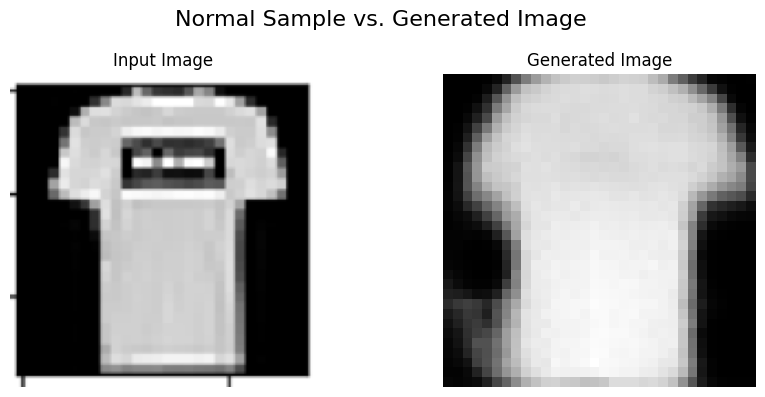

Anomal Class

Reconstruction error: tensor([0.6969], grad_fn=<MeanBackward1>)


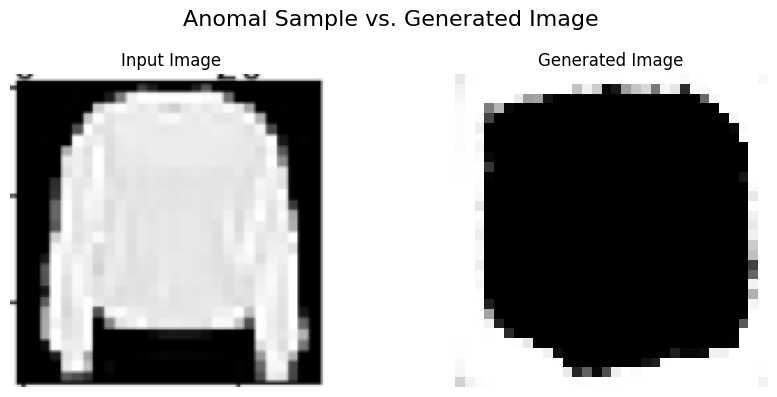

In [ ]:
model2 = GAN_SOTA()
model2.load_state_dict(torch.load("./GAN_pretrained"))

input_image_path = '0.png'     # t-shirt
#input_image_path = '1.png'     # trousers
#input_image_path = '4.png'     # coat
#input_image_path = '5.png'     # sandal
#input_image_path = '6.png'     # shirt
#input_image_path = '7.png'     # Sneaker
#input_image_path = '8.png'     # bag

compare_img(input_image_path, model2, "Normal Sample")

print("Anomal Class")
input_image_path = '6.png'
compare_img(input_image_path, model2, "Anomal Sample")

## AE
The Autoencoder was trained on the normal class, for this reason it will try to generate an image as good as possible in the normal case, while will show poor results in the anomal case.


Reconstruction error: tensor([0.0197], grad_fn=<MeanBackward1>)


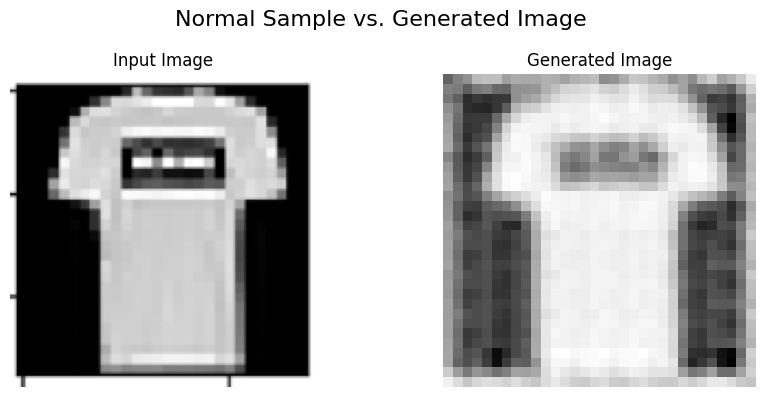

Anomal Class

Reconstruction error: tensor([0.0042], grad_fn=<MeanBackward1>)


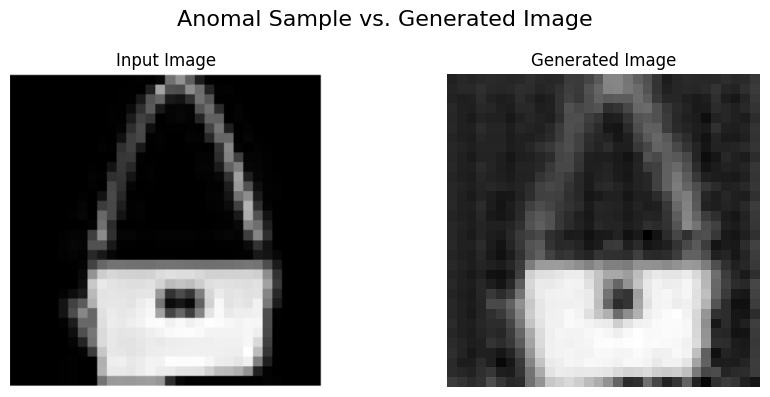

In [73]:
input_image_path = '0.png'     # t-shirt
#input_image_path = '1.png'     # trousers
#input_image_path = '4.png'     # coat
#input_image_path = '5.png'     # sandal
#input_image_path = '6.png'     # shirt
#input_image_path = '7.png'     # Sneaker
#input_image_path = '8.png'     # bag

compare_img(input_image_path, model, "Normal Sample")

print("Anomal Class")
input_image_path = '8.png'
compare_img(input_image_path, model, "Anomal Sample")

# Conclusions
The RandomGuesser is by far the worst model, representing the minimum baseline performances based on the AUROC metric. On the other hand the Autoencoder resulted in a relatively fast training, with a relatively high AUROC values. But by looking at the experimental results, the GAN-based model, as expected, acquired the highest performances above the three, due to the emphasized error on the anomal class, which results in a more evident difference between the two classes in particular after the introduction of the skip-connections. 

Except for the RandomGuesser, is reasonably to say that were possible even better results with additional training perfromed.

# Bibliography
[1] GAN-based Anomaly Detection in Imbalance Problems [https://paperswithcode.com/paper/gan-based-anomaly-detection-in-imbalance](https://paperswithcode.com/paper/gan-based-anomaly-detection-in-imbalance)

[2] FashionMNIST dataset. [https://github.com/zalandoresearch/fashion-mnist](https://github.com/zalandoresearch/fashion-mnist)

[3] Area Under the Receiver-Operating Characteristics (AUROC) metric [https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html)

[4] Ronneberger, Fischer, Brox. _U-net: Convolutional networks for biomedical image segmentation. In: International Conference on Medical image computing and computer-assisted intervention_. pp. 234–241. Springer (2015) [https://arxiv.org/abs/1505.04597](https://arxiv.org/abs/1505.04597)

#########################################
# GAN Tests

In [5]:

class ENCODER(pl.LightningModule):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=4, stride=2, padding=1)  #out 16x16
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1) #out 8x8
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1) #out 4x4
        self.conv4 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1) #out 2x2

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        return x

class DECODER(pl.LightningModule):
    def __init__(self):
        super().__init__()

        self.tr_conv1 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=4, stride=2, padding=1) #out 4x4
        self.tr_conv2 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1) #out 8x8
        self.tr_conv3 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1) #out 16x16
        self.tr_conv4 = nn.ConvTranspose2d(in_channels=64, out_channels=1, kernel_size=4, stride=2, padding=1) #out 32x32

    def forward(self, x):
        x = F.relu(self.tr_conv1(x))
        x = F.relu(self.tr_conv2(x))
        x = F.relu(self.tr_conv3(x))
        x = F.tanh(self.tr_conv4(x))
        return x


class GENERATOR(pl.LightningModule):
    def __init__(self):
        super().__init__()

        self.encoder = ENCODER()
        #self.decoder = DECODER()
        # Decoder
        self.tr_conv1 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=4, stride=2, padding=1)
        self.tr_conv2 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1)
        self.tr_conv3 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1)
        self.tr_conv4 = nn.ConvTranspose2d(in_channels=64, out_channels=1, kernel_size=4, stride=2, padding=1)



    def forward(self, x):
        # encoder
        enc1 = F.relu(self.encoder.conv1(x))
        enc2 = F.relu(self.encoder.conv2(enc1))
        enc3 = F.relu(self.encoder.conv3(enc2))
        enc4 = F.relu(self.encoder.conv4(enc3))

        # decoder with skip connections
        dec1 = F.relu(self.tr_conv1(enc4))
        dec2 = F.relu(self.tr_conv2(torch.cat([dec1, enc3], dim=1)))
        dec3 = F.relu(self.tr_conv3(torch.cat([dec2, enc2], dim=1)))
        dec4 = F.tanh(self.tr_conv4(torch.cat([dec3, enc1], dim=1)))


        return dec4


class DISCRIMINATOR(pl.LightningModule):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=4, stride=2, padding=1)  #out 32x16x16
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1) #out 64x8x8
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1) #out 128x4x4
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=4, stride=1, padding=1) #out 32x3x3
        self.conv5 = nn.Conv2d(in_channels=32, out_channels=1, kernel_size=4, stride=1, padding=1) #out 1x2x2

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        return x


class GAN_SOTA(pl.LightningModule):
    def __init__(self, lr=0.0002, display=False, b1=0.5, b2=0.999):
        super().__init__()
        self.lr = lr
        self.display = display

        self.save_hyperparameters()
        self.G = GENERATOR()
        self.Enc = self.G.encoder
        self.D_norm = DISCRIMINATOR()
        self.D_anom = DISCRIMINATOR()

        self.automatic_optimization = False
        self.test_step_outputs = [[], []]  # two dataloaders

        self.g_losses = []
        self.d_norm_losses = []
        self.d_anom_losses = []

    def forward(self, x):
        return self.G(x)

    def print_generator_parameters(self):
        for name, param in self.G.named_parameters():
            print(f"Generator Parameter Name: {name}")
            print(f"Parameter Value:\n{param}")

    def patch_loss(self, X, generated_X, n=3):
        # Calculate the L1 loss for each patch
        patch_errors = torch.abs(X - generated_X)
        patch_errors_reshaped = patch_errors.view(patch_errors.size(0), patch_errors.size(1), -1)
        mean_patch_errors = patch_errors_reshaped.mean(dim=-1)

        # Select the top n patches
        sorted_patch_indices = torch.argsort(mean_patch_errors, dim=-1, descending=True)
        top_patch_indices = sorted_patch_indices[:, :n]
        # Calculate the average of the top n patch errors
        
        top_patch_errors = torch.gather(mean_patch_errors, dim=-1, index=top_patch_indices)
        avg_top_patch_errors = top_patch_errors.mean()
        return avg_top_patch_errors

    def show_batch_image(self, batch):
        X, Y = batch
        image = X[0].detach().cpu().numpy()
        plt.figure(figsize=(5, 5))
        plt.title("Label: {}".format(Y[0]))
        plt.imshow(image[0], cmap='gray')  # Assuming the input image is single-channel (gray)
        plt.axis('off')
        plt.show()


    #The generator is trained to output 1 from normal data and 0 from anomaly data
    def training_step(self, batch, batch_idx):
        g_opt, d_norm_opt, d_anom_opt = self.optimizers()

        X, Y = batch
        batch_size = X.shape[0]

        real_label = torch.ones((batch_size, 1, 2, 2), device=self.device)
        fake_label = torch.zeros((batch_size, 1, 2, 2), device=self.device)

        errD_anomal = 0
        errD_normal = 0

        if (Y.squeeze() == 1):
            generated_X = self.G(X)
            discriminated_X = self.D_norm(X)
            discriminated_G = self.D_norm(generated_X)
            encoded_X = self.G.encoder(X)

            #------------------------#
            # Optimize Discriminator #
            d_norm_opt.zero_grad()

            # NORM ADV LOSS
            Norm_adv_loss = (((discriminated_X - real_label)**2) + ((discriminated_G - fake_label)**2))

            errD_normal = (Norm_adv_loss.mean())

            errD = errD_normal
            self.manual_backward(errD_normal.mean())
            d_norm_opt.step()

            #--------------------#
            # Optimize Generator #
            g_opt.zero_grad()

            generated_X = self.G(X)
            discriminated_X = self.D_norm(X)
            discriminated_G = self.D_norm(generated_X)
            encoded_X = self.G.encoder(X)

            # L1 RECONSTRUCTION ERROR
            l1_loss = F.l1_loss(X, generated_X)

            # PATCH L1 LOSS
            patch_loss = self.patch_loss(X, generated_X)

            # LATENT VECTOR LOSS
            latent_loss = F.l1_loss(encoded_X, self.G.encoder(generated_X))

            # ADVERSARIAL LOSS
            norm_adv_loss = ((discriminated_G - real_label)**2)

            errG_normal = patch_loss*(1.5) + (norm_adv_loss)*(0.5) + (latent_loss)*(0.5) + (l1_loss)*(1.5)
            errG = errG_normal.mean()
            self.manual_backward(errG_normal.mean())
            g_opt.step()

            self.log_dict({"g_loss": torch.tensor(errG).mean(), "d_normal_loss": torch.tensor(errD).mean()}, prog_bar=True)

        else:
            generated_X = self.G(X)
            discriminated_X = self.D_anom(X)
            discriminated_G = self.D_anom(generated_X)

            # Optimize Discriminator #
            d_anom_opt.zero_grad()

            # ANOM ADV LOSS
            Anom_adv_loss = ((((discriminated_X - real_label)**2) + ((discriminated_G - fake_label)**2)))

            errD_anomal = (Anom_adv_loss.mean())

            errD = errD_anomal
            self.manual_backward(errD_anomal.mean())
            d_anom_opt.step()

            # Optimize Generator #
            g_opt.zero_grad()
            generated_X = self.G(X)
            discriminated_X = self.D_anom(X)
            discriminated_G = self.D_anom(generated_X)
            encoded_X = self.G.encoder(X)

            # ANOM ADVERS LOSS
            anom_adv_loss = ((discriminated_G - fake_label)**2)

            # ABC LOSS
            abc_loss = -torch.log(1 - torch.exp(-F.l1_loss(generated_X, X)))

            errG_anomal = anom_adv_loss*(1) + (abc_loss)*(0.5)
            errG = errG_anomal.mean()
            self.manual_backward(errG_anomal.mean())
            g_opt.step()

            self.log_dict({"g_loss": errG, "d_anomal_loss": errD}, prog_bar=True)

        self.g_losses.append(errG.item())
        self.d_norm_losses.append(errD_normal.item())
        self.d_anom_losses.append(errD_anomal.item())

        return {"g_loss": errG, "d_norm_loss": errD_normal, "d_anom_loss": errD_anomal}

    def test_step(self, batch, batch_idx):
        X, Y = batch

        generated_X = self.G(X)

        # Calculate L1 reconstruction error instead of MSE
        reconstruction_error = F.mse_loss(generated_X, X, reduction='none')
        reconstruction_error = reconstruction_error.view(reconstruction_error.size(0), -1).mean(dim=1)  # Calculate mean error over pixels
        self.test_step_outputs[0].append(reconstruction_error)
        self.test_step_outputs[1].append(Y)

        if self.display:
            print("generated_X:", generated_X)
            print("reconstruction_error:", reconstruction_error)
            self.show_batch_image(batch)

        return {"reconstruction_error": reconstruction_error, "true_labels": Y}

    def on_test_epoch_end(self):
        all_reconstruction_errors = torch.cat(self.test_step_outputs[0])
        all_true_labels = torch.cat(self.test_step_outputs[1])

        anomaly_threshold = 0.5
        predicted_labels = (all_reconstruction_errors < anomaly_threshold).float().cpu().numpy()
        true_labels = all_true_labels.squeeze().float().cpu().numpy()

        # Calculate AUROC
        auroc = roc_auc_score(true_labels, predicted_labels)

        self.log("auroc", (auroc), prog_bar=True)

        # Clear the test step outputs after processing them
        self.test_step_outputs = [[], []]

    def on_epoch_end(self):
        self.log('g_loss_epoch', self.trainer.logged_metrics['g_loss'].mean(), prog_bar=True)
        self.log('d_anomal_loss_epoch', self.trainer.logged_metrics['d_anomal_loss'].mean(), prog_bar=True)
        self.log('d_normal_loss_epoch', self.trainer.logged_metrics['d_normal_loss'].mean(), prog_bar=True)


    def configure_optimizers(self):
        lr = self.hparams.lr
        b1 = self.hparams.b1
        b2 = self.hparams.b2

        opt_g = torch.optim.Adam(self.G.parameters(), lr=self.lr, betas=(b1, b2))
        opt_d_norm = torch.optim.Adam(self.D_norm.parameters(), lr=self.lr, betas=(b1, b2))
        opt_d_anom = torch.optim.Adam(self.D_anom.parameters(), lr=self.lr, betas=(b1, b2))
        return opt_g, opt_d_norm, opt_d_anom


In [15]:
# Hyperparameters
'''
BATCH_SIZE = 1
epochs = 15
learning_rate = 0.0001
subsampling = False
subsamples = 2000
accelerator_enabled = True
display = False
'''
BATCH_SIZE = 1
epochs = 40
learning_rate = 0.0001
subsampling = False
subsamples = 1000
accelerator_enabled = True
display = False
# Utilities
checkpoint_path = './GAN/checkpoints'
os.makedirs(checkpoint_path, exist_ok=True)

checkpoint_callback = ModelCheckpoint(
    dirpath=checkpoint_path,
    filename="GAN_{epochs}_ckpt",
    monitor='auc',
    mode='min',
    save_last=True,
    save_top_k=-1,
)


# Initialize dataset
data_module = AnomalyDetectionDataModule(batch_size=BATCH_SIZE,
                                         subsampling=subsampling,
                                         subsamples=subsamples,
                                         model='GAN',
                                         normal_class=0)


# Initialize models and trainers
if torch.cuda.is_available() and accelerator_enabled:
  print("GPU")
  model = GAN_SOTA(lr=learning_rate, display=display).to("cuda")
  trainer = pl.Trainer(accelerator="cuda",
                       max_epochs=epochs,
                       callbacks=[TQDMProgressBar(),
                                  checkpoint_callback]
                       )
else :
  print("CPU")
  model = GAN_SOTA(lr=learning_rate, display=display).to("cpu")
  trainer = pl.Trainer(accelerator="cpu",
                       max_epochs=epochs,
                       callbacks=[TQDMProgressBar(),
                                  checkpoint_callback]
                       )


# Train and save
trainer.fit(model, data_module)
trainer.save_checkpoint("/GAN/checkpoints/GAN.ckpt")
torch.save(model.state_dict(), "./GAN/GAN_40ep_00001lr")

# Testing
test_results = trainer.test(model, data_module)
print(test_results)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


GPU


c:\Users\espda\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:617: UserWarning: Checkpoint directory C:\Users\espda\OneDrive\Desktop\Università\Magistrale - Artificial Intelligence & Robotics (2022-2023)\Deep Learning\Progetto\GAN\checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type          | Params
-----------------------------------------
0 | G      | GENERATOR     | 5.5 M 
1 | Enc    | ENCODER       | 2.8 M 
2 | D_norm | DISCRIMINATOR | 296 K 
3 | D_anom | DISCRIMINATOR | 296 K 
-----------------------------------------
6.1 M     Trainable params
0         Non-trainable params
6.1 M     Total params
24.408    Total estimated model params size (MB)
c:\Users\espda\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:438: PossibleUserWarning: The d

Epoch 0:   0%|          | 3/11994 [00:00<10:26, 19.13it/s, v_num=279, g_loss=1.990, d_anomal_loss=0.998, d_normal_loss=1.000]

C:\Users\espda\AppData\Local\Temp\ipykernel_8980\4045874823.py:171: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.log_dict({"g_loss": torch.tensor(errG).mean(), "d_normal_loss": torch.tensor(errD).mean()}, prog_bar=True)


Epoch 36:  26%|██▌       | 3094/11994 [01:42<04:54, 30.27it/s, v_num=279, g_loss=0.724, d_anomal_loss=0.000702, d_normal_loss=0.00232]   

GPU


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\espda\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:486: PossibleUserWarning: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
c:\Users\espda\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\data_connect

Testing DataLoader 0: 100%|██████████| 1999/1999 [00:06<00:00, 331.36it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           auroc           │    0.4868663663663663     │
└───────────────────────────┴───────────────────────────┘

[{'auroc': 0.4868663663663663}]



Reconstruction error: tensor([2.2633], grad_fn=<MeanBackward1>)


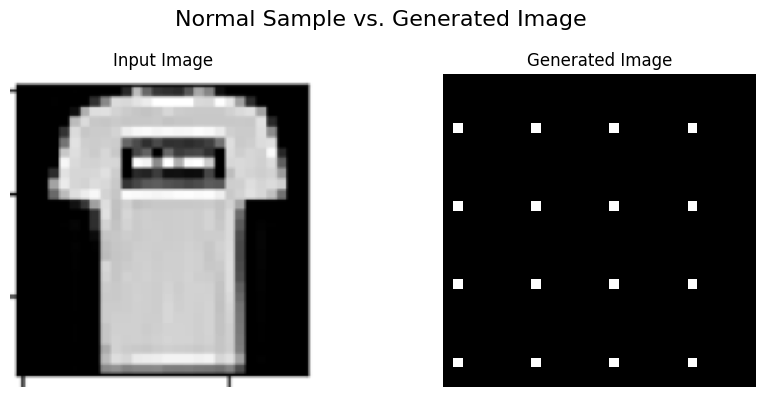

Anomal Class

Reconstruction error: tensor([2.6413], grad_fn=<MeanBackward1>)


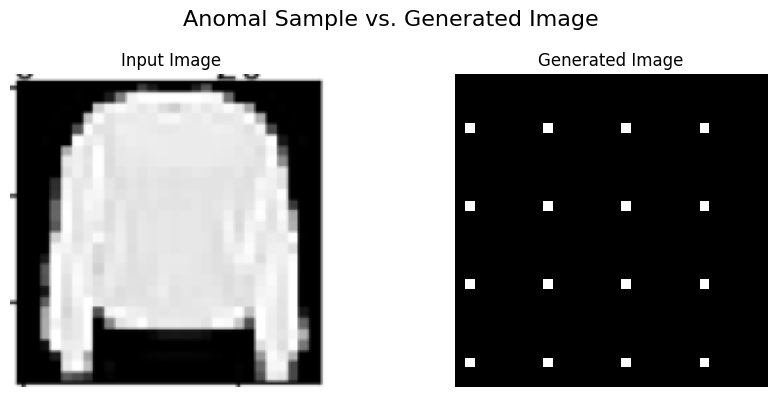

In [10]:
#model = GAN_SOTA()
model.load_state_dict(torch.load("./GAN/GAN_40ep_00001lr"))

input_image_path = '0.png'     # t-shirt
#input_image_path = '1.png'     # trousers
#input_image_path = '4.png'     # coat
#input_image_path = '5.png'     # sandal
#input_image_path = '6.png'     # shirt
#input_image_path = '7.png'     # Sneaker
#input_image_path = '8.png'     # bag

compare_img(input_image_path, model, "Normal Sample")

print("Anomal Class")
input_image_path = '6.png'
compare_img(input_image_path, model, "Anomal Sample")

In [6]:
# Hyperparameters
BATCH_SIZE = 1
epochs = 5
learning_rate = 0.0001
subsampling = False
subsamples = 1000
accelerator_enabled = True
display = False
# Utilities
checkpoint_path = './GAN/checkpoints'
os.makedirs(checkpoint_path, exist_ok=True)

checkpoint_callback = ModelCheckpoint(
    dirpath=checkpoint_path,
    filename="GAN_{epochs}_ckpt",
    monitor='auc',
    mode='min',
    save_last=True,
    save_top_k=-1,
)


# Initialize dataset
data_module = AnomalyDetectionDataModule(batch_size=BATCH_SIZE,
                                         subsampling=subsampling,
                                         subsamples=subsamples,
                                         model='GAN',
                                         normal_class=0)


# Initialize models and trainers
if torch.cuda.is_available() and accelerator_enabled:
  print("GPU")
  model = GAN_SOTA(lr=learning_rate, display=display).to("cuda")
  trainer = pl.Trainer(accelerator="cuda",
                       max_epochs=epochs,
                       callbacks=[TQDMProgressBar(),
                                  checkpoint_callback]
                       )
else :
  print("CPU")
  model = GAN_SOTA(lr=learning_rate, display=display).to("cpu")
  trainer = pl.Trainer(accelerator="cpu",
                       max_epochs=epochs,
                       callbacks=[TQDMProgressBar(),
                                  checkpoint_callback]
                       )


# Train and save
trainer.fit(model, data_module)
trainer.save_checkpoint("/GAN/checkpoints/GAN.ckpt")
torch.save(model.state_dict(), "./GAN/GAN_5ep_00001lr")

# Testing
test_results = trainer.test(model, data_module)
print(test_results)

GPU


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
c:\Users\espda\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:617: UserWarning: Checkpoint directory C:\Users\espda\OneDrive\Desktop\Università\Magistrale - Artificial Intelligence & Robotics (2022-2023)\Deep Learning\Progetto\GAN\checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type         

Epoch 0:   0%|          | 20/11994 [00:02<28:11,  7.08it/s, v_num=282, g_loss=1.980, d_anomal_loss=1.000, d_normal_loss=1.000] 

C:\Users\espda\AppData\Local\Temp\ipykernel_13760\4045874823.py:171: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.log_dict({"g_loss": torch.tensor(errG).mean(), "d_normal_loss": torch.tensor(errD).mean()}, prog_bar=True)


Epoch 0: 100%|██████████| 11994/11994 [04:31<00:00, 44.25it/s, v_num=282, g_loss=2.980, d_anomal_loss=1.000, d_normal_loss=1.000] 

c:\Users\espda\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:359: UserWarning: `ModelCheckpoint(monitor='auc')` could not find the monitored key in the returned metrics: ['g_loss', 'd_anomal_loss', 'd_normal_loss', 'epoch', 'step']. HINT: Did you call `log('auc', value)` in the `LightningModule`?
  warning_cache.warn(m)


Epoch 4: 100%|██████████| 11994/11994 [03:57<00:00, 50.53it/s, v_num=282, g_loss=0.144, d_anomal_loss=1.000, d_normal_loss=1.000] 

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 11994/11994 [03:57<00:00, 50.49it/s, v_num=282, g_loss=0.144, d_anomal_loss=1.000, d_normal_loss=1.000]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\espda\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:486: PossibleUserWarning: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
c:\Users\espda\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:438: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 1999/1999 [00:03<00:00, 603.99it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           auroc           │    0.9144334334334334     │
└───────────────────────────┴───────────────────────────┘

[{'auroc': 0.9144334334334334}]



Reconstruction error: tensor([0.2768], grad_fn=<MeanBackward1>)


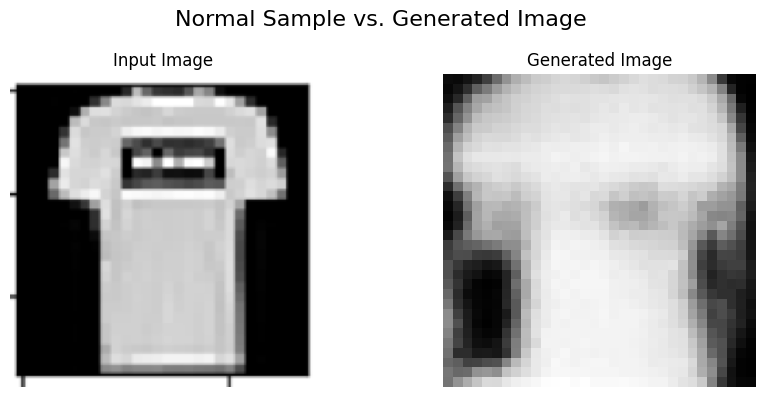

Anomal Class

Reconstruction error: tensor([0.6456], grad_fn=<MeanBackward1>)


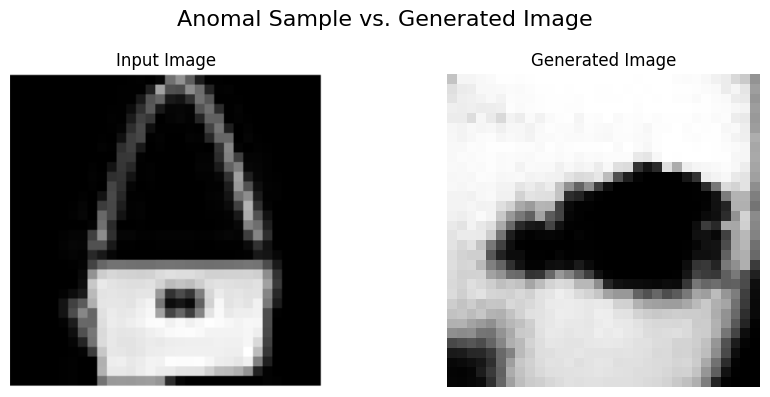

In [9]:
#model = GAN_SOTA()
#model.load_state_dict(torch.load("./GAN_pretrained"))

input_image_path = '0.png'     # t-shirt
#input_image_path = '1.png'     # trousers
#input_image_path = '4.png'     # coat
#input_image_path = '5.png'     # sandal
#input_image_path = '6.png'     # shirt
#input_image_path = '7.png'     # Sneaker
#input_image_path = '8.png'     # bag

compare_img(input_image_path, model, "Normal Sample")

print("Anomal Class")
input_image_path = '8.png'
compare_img(input_image_path, model, "Anomal Sample")

########################################################
# AE test

In [26]:
# Utilities
checkpoint_path = './AE/checkpoints'
os.makedirs(checkpoint_path, exist_ok=True)

checkpoint_callback = ModelCheckpoint(
    dirpath=checkpoint_path,
    filename="AE_{epoch}_ckpt",
    monitor='loss',
    mode='min',
    save_last=True,
    save_top_k=-1,
)
# Hyperparameters
'''
BATCH_SIZE = 1
epochs = 13
learning_rate = 0.001
subsampling = True
subsamples = 3000
accelerator_enabled = True
display = False
'''
BATCH_SIZE = 1
epochs = 5
learning_rate = 0.01
subsampling = False
subsamples = 200
accelerator_enabled = True
display = False

# Initialize dataset
data_module = AnomalyDetectionDataModule(batch_size=BATCH_SIZE,
                                         subsampling=subsampling,
                                         subsamples=subsamples,
                                         model='AE',
                                         normal_class=0)

# Initialize model and trainer

if torch.cuda.is_available() and accelerator_enabled:
  print("GPU")
  model = AE_based(lr=learning_rate, display=display).to("cuda")
  trainer = pl.Trainer(accelerator="cuda",
                       max_epochs=epochs,
                       callbacks=[TQDMProgressBar(),
                                  checkpoint_callback]
                       )
else :
  print("CPU")
  model = AE_based(lr=learning_rate, display=display).to("cpu")
  trainer = pl.Trainer(accelerator="cpu",
                       max_epochs=epochs,
                       callbacks=[TQDMProgressBar(),
                                  checkpoint_callback]
                       )

# Trainer
trainer.fit(model, datamodule=data_module)
trainer.save_checkpoint("checkpoints/AE.ckpt")
torch.save(model.state_dict(), "./AE/AE_15ep_0001")

# Testing
test_results = trainer.test(model, data_module)
print(test_results)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


GPU


c:\Users\espda\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:617: UserWarning: Checkpoint directory C:\Users\espda\OneDrive\Desktop\Università\Magistrale - Artificial Intelligence & Robotics (2022-2023)\Deep Learning\Progetto\AE\checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type        | Params
-------------------------------------
0 | AE   | Autoencoder | 6.9 K 
1 | enc  | Sequential  | 4.8 K 
-------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
c:\Users\espda\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:438: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider i

Epoch 4: 100%|██████████| 6000/6000 [00:25<00:00, 237.98it/s, v_num=289, loss=0.487] 

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 6000/6000 [00:25<00:00, 237.89it/s, v_num=289, loss=0.487]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\espda\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:486: PossibleUserWarning: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
c:\Users\espda\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:438: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 1999/1999 [00:02<00:00, 666.57it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           auroc           │    0.6197842842842843     │
└───────────────────────────┴───────────────────────────┘

[{'auroc': 0.6197842842842843}]



Reconstruction error: tensor([0.0178], grad_fn=<MeanBackward1>)


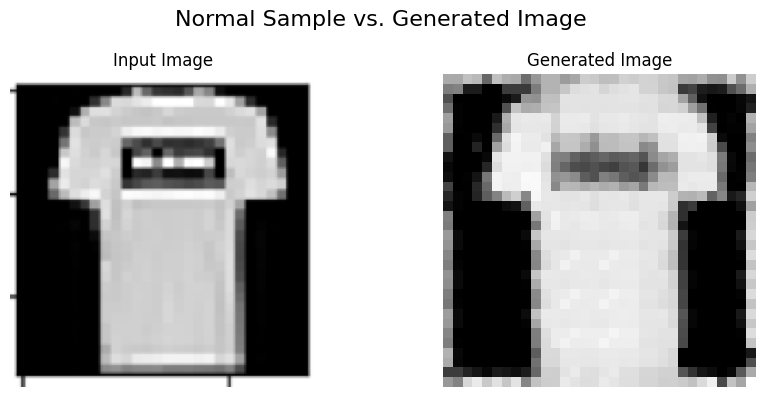

Anomal Class

Reconstruction error: tensor([0.0093], grad_fn=<MeanBackward1>)


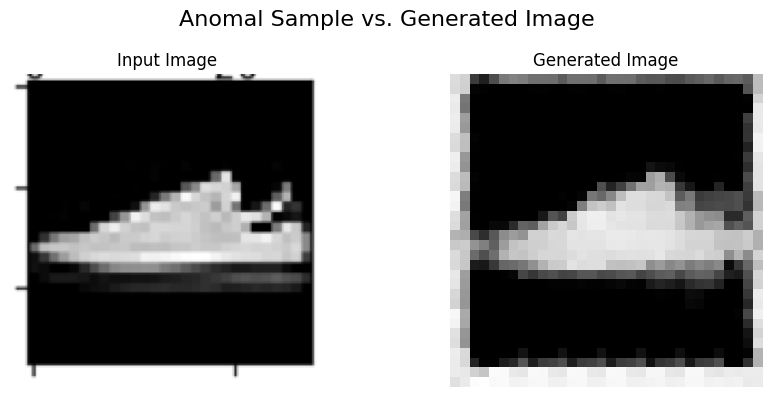

In [29]:
#model = AE_based()
#model.load_state_dict(torch.load("./AE/AE_200samples_5ep"))

input_image_path = '0.png'     # t-shirt
#input_image_path = '1.png'     # trousers
#input_image_path = '4.png'     # coat
#input_image_path = '5.png'     # sandal
#input_image_path = '6.png'     # shirt
#input_image_path = '7.png'     # Sneaker
#input_image_path = '8.png'     # bag

compare_img(input_image_path, model, "Normal Sample")

print("Anomal Class")
input_image_path = '1.png'
compare_img(input_image_path, model, "Anomal Sample")